In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import rasterio
from scipy.ndimage import gaussian_filter

## Helper functions used throughout

In [3]:
def get_cumulative_area(df, total_area, minimum = 0):
    df = df[df.diameter > minimum]
    # Sort the dataframe by diameter in descending order
    df_sorted = df.sort_values(by=['diameter'], ascending=False)

    # Calculate the cumulative area
    df_sorted['cumulative_area'] = df_sorted['boulder_area'].cumsum()

    # Extract the diameters and cumulative areas into separate arrays
    diameters = df_sorted['diameter'].to_numpy()
    cumulative_areas = df_sorted['cumulative_area'].to_numpy()
    cumulative_areas /= total_area
    
    return diameters, cumulative_areas

def rock_abundance_function(D, k, q):
    return k * np.exp(-q * D)

# Figure 1 (Boulder Maps & BoulderNet Rock Abundance vs Diameter)

Figures 1 a-c were made with QGIS. 

(a) uses APOLLO17_ORTHOMOSAIC_50CM.TIFF as background and BoulderNetBoulders.shp

(b) uses DivinerRockAbundanceMap.tif

(c) uses BoulderNetRockAbundanceMap.tif

# Figure 2 (Overall Rock Abundance Model Fit)

In [4]:
bouldersGDF= pd.read_csv("Data/BouldersWithTileID.csv")

NUM_TILES = 864
total_area = NUM_TILES * bouldersGDF.tile_area[1]

bouldersGDF = bouldersGDF[['boulder_id', 'scores', 'boulder_area']]
bouldersGDF['diameter'] = 2 * np.sqrt(bouldersGDF['boulder_area'] / np.pi)

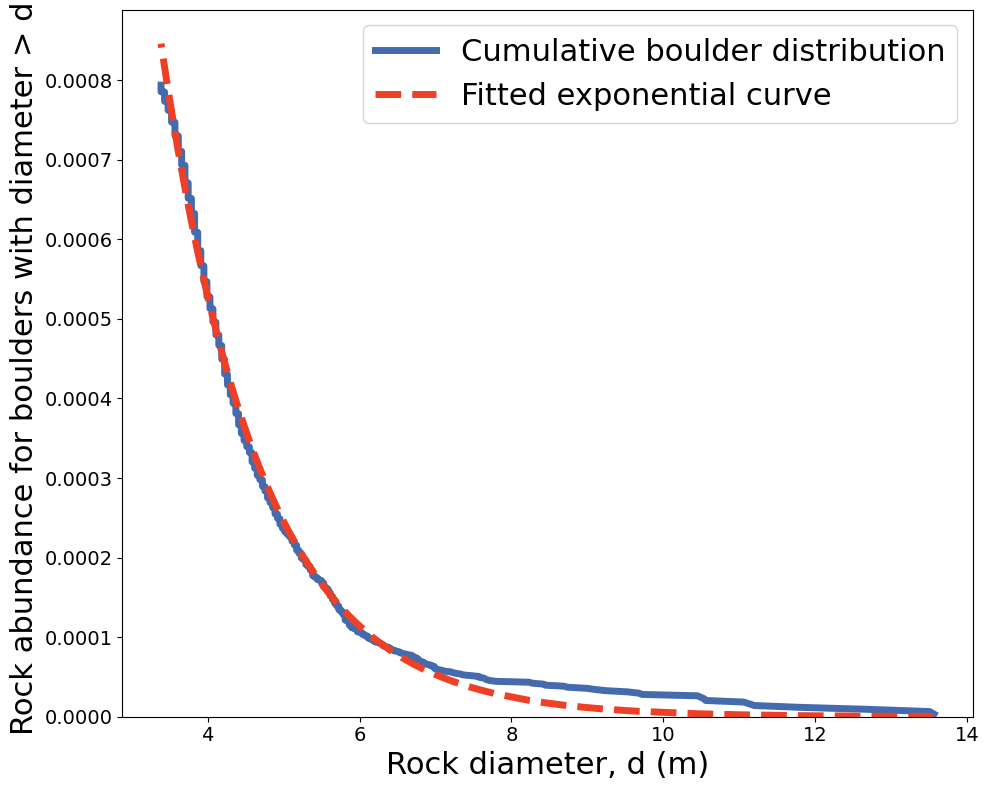

k: 0.011338255209924503
q: 0.7666917564384282
0.005267156579510273


In [5]:
diameterVals, arealFractionVals = get_cumulative_area(bouldersGDF, total_area=total_area, minimum=3.385)

params, pcov = curve_fit(lambda D,k,q:  rock_abundance_function(D, k, q),  diameterVals,  arealFractionVals,  p0=(0.01, 1))
k = params[0]
q = params[1]

extended_diameters = np.concatenate([
    np.linspace(1, min(diameterVals), 50),  # Add points between 1m and your first measurement
    diameterVals
])

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(diameterVals, arealFractionVals, 'xkcd:french blue', label="Cumulative boulder distribution", linewidth=5)
ax.plot(diameterVals, rock_abundance_function(diameterVals, k, q), 'xkcd:tomato', linestyle="--", label="Fitted exponential curve", linewidth=5)
ax.set_xlabel("Rock diameter, d (m)", fontsize=22)
ax.set_ylabel("Rock abundance for boulders with diameter > d ", fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=14)
legend = ax.legend(prop={'size': 22})
plt.ylim(0)

plt.tight_layout()

plt.savefig('Figure 2 plot.png', dpi=300, bbox_inches='tight') 

plt.show()

print(f'k: {k}')
print(f'q: {q}')
print(rock_abundance_function(1, k, q)) 

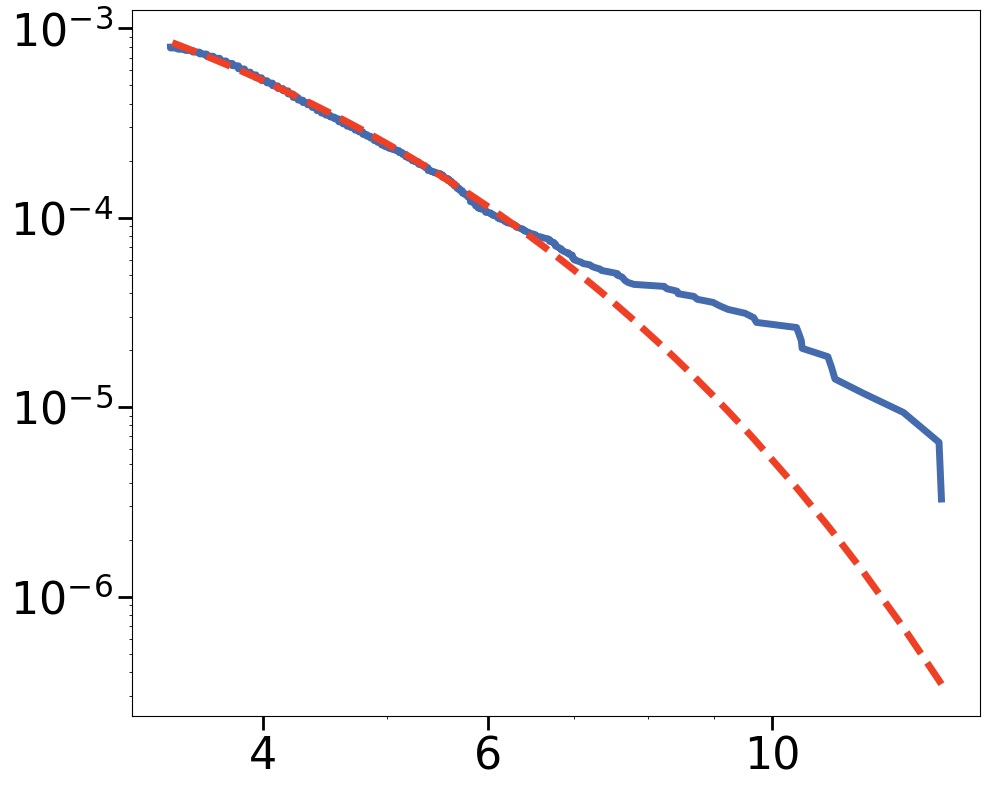

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(diameterVals, arealFractionVals, 'xkcd:french blue', label="Cumulative boulder distribution", linewidth=5)
ax.plot(diameterVals, rock_abundance_function(diameterVals, k, q), 'xkcd:tomato', linestyle="--", label="Fitted exponential curve", linewidth=5)
plt.xscale('log')
plt.yscale('log')
ax.set_xlabel("", fontsize=22)
ax.set_ylabel("", fontsize=22)
ax.set_xticks([4, 6, 10], ['4', '6', '10'])
ax.tick_params(axis='both', which='major', labelsize=32, length=10, width = 2)
ax.tick_params(axis='x', which='minor', labelsize=32)


plt.savefig('Figure 2 log log inset.png', dpi=300) 
plt.tight_layout()

# Figure 3 (Smoothing Effect)

In [7]:
boulderNet_map_ra = "Data/BoulderNetRockAbundanceMap.tif"
diviner_map_ra = "Data/DivinerRockAbundanceMap.tif"

ds = rasterio.open(boulderNet_map_ra)
boulderNetRA = ds.read(1)
ds = rasterio.open(diviner_map_ra)
divinerRA = ds.read(1)
ds = None

Blurring the image

In [8]:
sigmas = [1.69, 0.78]

with rasterio.open(boulderNet_map_ra) as src:
    image_data = src.read(1)  
    blurred_image = gaussian_filter(image_data, sigma = sigmas)

In [8]:
with rasterio.open(
    "BlurredBoulderNetRAMap.tif",
    'w',
    width=src.width,
    height=src.height,
    count=1,  # Number of bands
    dtype=rasterio.float32,
    crs=src.crs, 
    transform=src.transform, 
) as dst:
    dst.write(blurred_image, 1)

CPLE_AppDefinedError: Deleting BlurredBoulderNetRAMap.tif failed: Permission denied

In [9]:
blurredBoulderNet_map_ra = "BlurredBoulderNetRAMap.tif"
ds = rasterio.open(blurredBoulderNet_map_ra)
blurredBoulderNetRA = ds.read(1)
ds = None

No Smoothing Graph (Figure 3c)

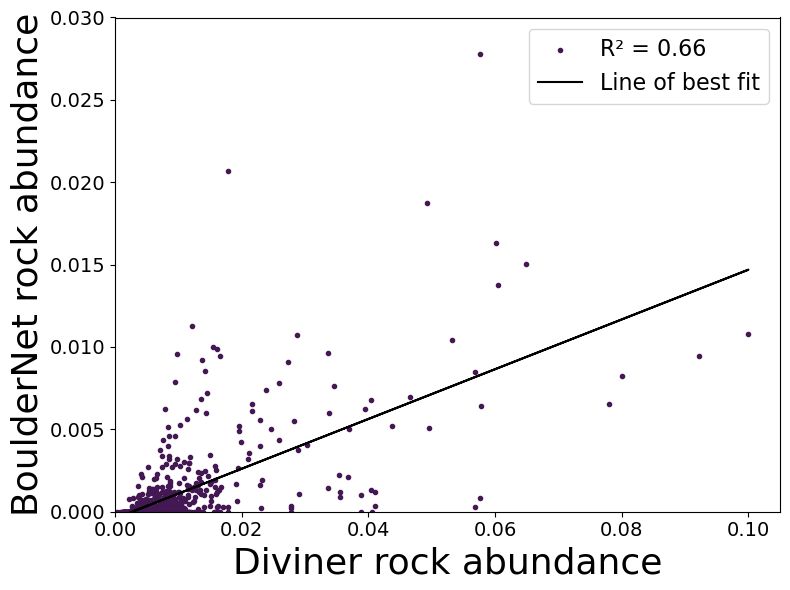

In [10]:
diviner_ra_vals = divinerRA.flatten()  
boulderNet_ra_vals = boulderNetRA.flatten()

plt.figure(figsize=(8, 6))  

r_squared = np.corrcoef(diviner_ra_vals, boulderNet_ra_vals)[0][1]
plt.scatter(diviner_ra_vals, boulderNet_ra_vals, label=f"R² = {r_squared:.2f}", marker='.', color="#431853")
a, b = np.polyfit(diviner_ra_vals, boulderNet_ra_vals, 1)
plt.plot(diviner_ra_vals, a * diviner_ra_vals + b, color="black", label='Line of best fit')

plt.xlabel("Diviner rock abundance", size=26)
plt.ylabel("BoulderNet rock abundance", size=26)

plt.xlim(xmin=0.0)
plt.ylim(ymin=0.0, ymax=0.03)

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.legend(fontsize=16)
plt.tight_layout() 
plt.savefig('Figure 3 c high_res_plot.png', dpi=300, bbox_inches='tight') 
plt.show()

Smoothing Graph (Figure 3d)

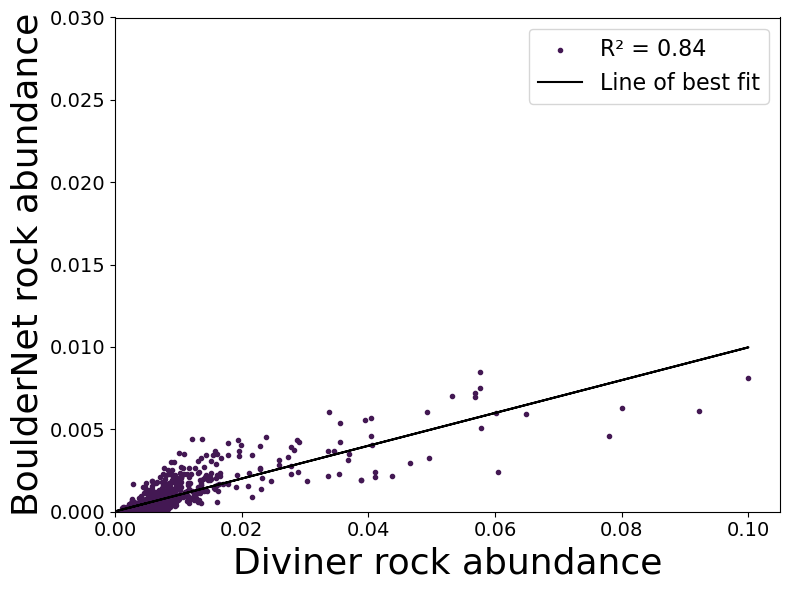

In [11]:
diviner_ra_vals = divinerRA.flatten() 
boulderNet_ra_vals = blurredBoulderNetRA.flatten()

plt.figure(figsize=(8, 6)) 

r_squared = np.corrcoef(diviner_ra_vals, boulderNet_ra_vals)[0][1]
plt.scatter(diviner_ra_vals, boulderNet_ra_vals, label=f"R² = {r_squared:.2f}", marker='.', color="#431853")
a, b = np.polyfit(diviner_ra_vals, boulderNet_ra_vals, 1)
plt.plot(diviner_ra_vals, a * diviner_ra_vals + b, color="black", label='Line of best fit')

plt.xlabel("Diviner rock abundance", size=26)
plt.ylabel("BoulderNet rock abundance", size=26)

plt.xlim(xmin=0.0)
plt.ylim(ymin=0.0, ymax=0.03)

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('Figure 3 d high_res_plot.png', dpi=300, bbox_inches='tight') 
plt.show()

# Figures S3 and 4 (Diviner BoulderNet Comparison)

In [12]:
bouldersGDF= pd.read_csv("Data/BouldersWithTileID.csv")
bouldersGDF['diameter'] = 2 *np.sqrt(bouldersGDF['boulder_area'] / np.pi)
tilesDf = pd.read_csv("Data/TileDF.csv").rename(columns={'DivinerRAmean': 'DivinerRA'})

In [31]:
indicies_k = dict()
indicies_q = dict()
indicies_corr_ra = dict()

def get_tile_index(grid_height, x, y):
    return x *grid_height + y + 1

divinerRAs = []
boulderNetRAs = []
corrBoulderNetRAs = []
k_vals = []
q_vals = []
mean_diameters = []
num_boulders = []
min_diameters = []
max_diameters = []
tile_area = bouldersGDF.tile_area[0]
center_tile_indices = []
perc_errs = []
rmses = []

diameterValsList = []
arealFractionValsList = []

verbose = False # Set to true to have fit for each sliding window comparsion graphed
x_limit = 32
y_limit = 27
for xIndex in range(1, x_limit - 1):
    for yIndex in range(1, y_limit -1):
        potentialTileCoords = [(xIndex - 1, yIndex - 1),(xIndex - 0, yIndex - 1),(xIndex + 1, yIndex - 1),
                                (xIndex - 1, yIndex - 0),(xIndex - 0, yIndex - 0),(xIndex + 1, yIndex - 0),
                                (xIndex - 1, yIndex + 1),(xIndex - 0, yIndex + 1),(xIndex + 1, yIndex + 1)]
        
        potentialTileIndicies = [get_tile_index(y_limit, pos[0], pos[1]) for pos in potentialTileCoords]
        tileData = tilesDf[tilesDf["id"].isin(potentialTileIndicies)]
        avgArealFrac = tileData.ArealFrac.mean()
        
        if (len(tileData) == 0):
            continue
        
        divinerRA = tileData['DivinerRA'].mean()
        boulderNetRA = tileData['ArealFrac'].mean()

        
        boulders = bouldersGDF[bouldersGDF["id"].isin(potentialTileIndicies)] 
        if (len(boulders) < 100):
            continue

        divinerRAs.append(divinerRA)
        boulderNetRAs.append(boulderNetRA)  
        diameterVals, arealFractionVals = get_cumulative_area(boulders, total_area=tile_area*9, minimum=3.38) 

        params, pcov = curve_fit(lambda D,k,q:  rock_abundance_function(D, k, q),  diameterVals,  arealFractionVals,  p0=(0.01, 1))
        k = params[0]
        q = params[1]
        correct_rock_abundance = rock_abundance_function(1, k, q) 
        corrBoulderNetRAs.append(correct_rock_abundance)
        k_vals.append(k)
        q_vals.append(q)

        mean_diameter = np.mean(diameterVals)
        mean_diameters.append(mean_diameter)

        max_diameter = np.max(diameterVals)
        max_diameters.append(max_diameter)

        min_diameter = np.min(diameterVals)
        min_diameters.append(min_diameter)

        num_boulders.append(len(boulders))
        center_tile_indices.append(potentialTileIndicies[4])
        predicted_arealFractionVals = rock_abundance_function(diameterVals, k, q)
        residuals = arealFractionVals - predicted_arealFractionVals
        rmse = np.sqrt(np.mean(residuals**2))
        rmses.append(rmse)
        perc_err = np.mean(np.abs(arealFractionVals - predicted_arealFractionVals) / arealFractionVals)
        perc_errs.append(perc_err)

        diameterValsList.append(diameterVals) 
        arealFractionValsList.append(arealFractionVals) 

        
        if verbose:
            fig, ax = plt.subplots(figsize=(10, 8))
            ax.plot(diameterVals, arealFractionVals, 'xkcd:french blue', label="Cumulative boulder distribution", linewidth=5)
            ax.plot(diameterVals, rock_abundance_function(diameterVals, k, q), 'xkcd:tomato', linestyle="--", label="Fitted exponential curve", linewidth=5)
            ax.set_xlabel("Rock diameter, d (m)", fontsize=22)
            ax.set_ylabel("Rock abundance for boulders with diameter > d ", fontsize=22)
            ax.tick_params(axis='both', which='major', labelsize=14)
            legend = ax.legend(prop={'size': 22})
            plt.xscale('log')
            plt.yscale('log')

            # Add annotations
            text_y_positions = [0.02, 0.07, 0.12]  # Increased spacing between lines
            ax.text(0.02, text_y_positions[0], f'q: {q:.3f}', transform=ax.transAxes, fontsize=18)
            ax.text(0.02, text_y_positions[1], f'Diviner RA: {divinerRA:.3f}', transform=ax.transAxes, fontsize=18)
            ax.text(0.02, text_y_positions[2], f'BoulderNet RA: {correct_rock_abundance:.3f}', transform=ax.transAxes, fontsize=18)

            plt.tight_layout()
            plt.show()
 
        
        # For the data in Figure 7
        for index in potentialTileIndicies:
            if index not in indicies_k:
                indicies_k[index] = []
                indicies_q[index] = []
                indicies_corr_ra[index] = []
                
            indicies_k[index].append(k)
            indicies_q[index].append(q)
            indicies_corr_ra[index].append(correct_rock_abundance)

## Supplementary figure S3

In [32]:
import pandas as pd
df = pd.DataFrame({
    'q': q_vals,
    'DivinerRA': divinerRAs,
    'corrBoulderNetRA': corrBoulderNetRAs,
    'boulderNetRA': boulderNetRAs,
    'centerTile': center_tile_indices
})
df = df.round(3)
df['q'] = df['q'].round(2)

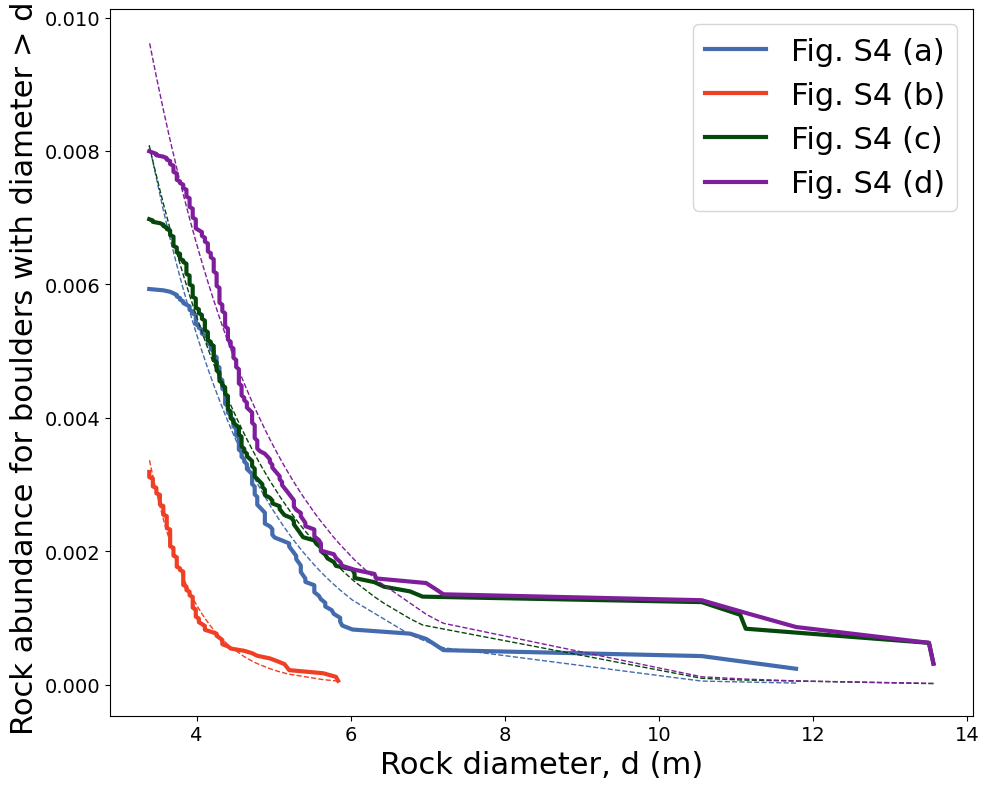

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))

# Define colors for different curves
colors = ['xkcd:french blue', 'xkcd:tomato', 'xkcd:forest green', 'xkcd:purple']

labels = ["Fig. S4 (a)",
"Fig. S4 (b)",
"Fig. S4 (c)",
"Fig. S4 (d)"]

# Plot each curve for the specified indices
indices = [38, 3, 34, 43]
for i, idx in enumerate(indices):
    # Plot the cumulative boulder distribution
    ax.plot(diameterValsList[idx], arealFractionValsList[idx], 
            color=colors[i], 
            label=labels[i], 
            linewidth=3)
    
    # Plot the fitted curve
    ax.plot(diameterValsList[idx], 
            rock_abundance_function(diameterValsList[idx], k_vals[idx], q_vals[idx]), 
            color=colors[i], 
            linestyle='--', 
            linewidth=1)

ax.set_xlabel("Rock diameter, d (m)", fontsize=22)
ax.set_ylabel("Rock abundance for boulders with diameter > d ", fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=14)
legend = ax.legend(prop={'size': 22})

plt.tight_layout()
plt.savefig('Figure S3.png', dpi=300, bbox_inches='tight') 
plt.show()

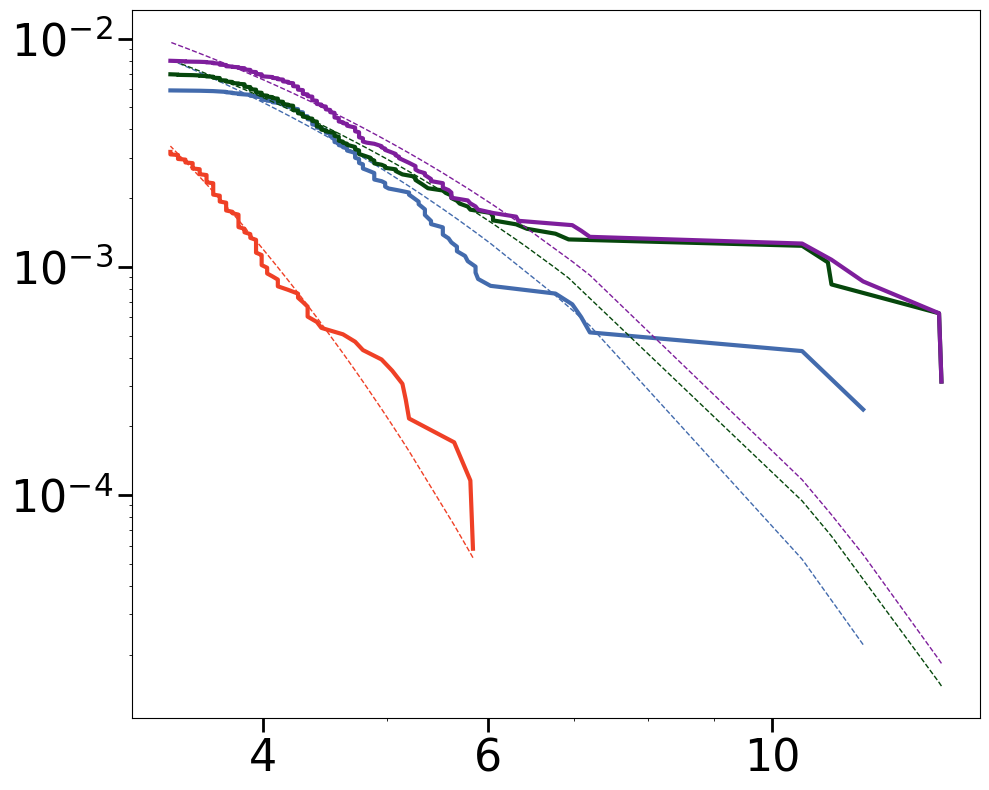

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['xkcd:french blue', 'xkcd:tomato', 'xkcd:forest green', 'xkcd:purple']

labels = ["(a) Low q, High Diviner RA, High BoulderNet RA",
"(b) High q, Low Diviner RA, High BoulderNet RA",
"(c) Low q, High Diviner RA, Low BoulderNet RA",
"(d) Low q, Low Diviner RA, Low BoulderNet RA"]

indices = [38, 3, 34, 43]
for i, idx in enumerate(indices):
    # Plot the cumulative boulder distribution
    ax.plot(diameterValsList[idx], arealFractionValsList[idx], 
            color=colors[i], 
            label=labels[i], 
            linewidth=3)
    
    # Plot the fitted curve
    ax.plot(diameterValsList[idx], 
            rock_abundance_function(diameterValsList[idx], k_vals[idx], q_vals[idx]), 
            color=colors[i], 
            linestyle='--',  
            linewidth=1)

ax.set_xlabel("Rock diameter, d (m)", fontsize=22)
ax.set_ylabel("Rock abundance for boulders with diameter > d ", fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=14)

# # Inset 
plt.xscale('log')
plt.yscale('log')
ax.set_xticks([4, 6, 10], ['4', '6', '10'])
ax.set_xlabel("", fontsize=22)
ax.set_ylabel("", fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=32, length=10, width = 2)
ax.tick_params(axis='x', which='minor', labelsize=32)

plt.tight_layout()
plt.savefig('Figure S3 inset.png', dpi=300, bbox_inches='tight') 
plt.show()

## Figure 4

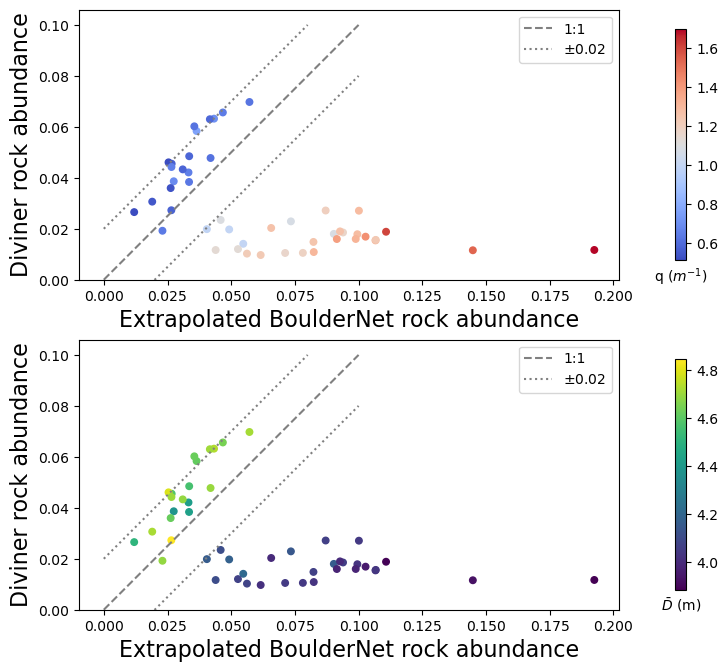

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# Figure 4a
diviner_ra_vals = np.asarray(divinerRAs) 
boulderNet_ra_vals = np.asarray(corrBoulderNetRAs)

ax1.scatter(boulderNet_ra_vals, diviner_ra_vals, marker='o', s=22, c=q_vals, cmap='coolwarm')
ax1.set_aspect('equal')  

x_vals = np.array([0, 0.1]) 
y_plus_20 = np.array([0, 0.08]) + .02 
y_minus_20 = x_vals - 0.02

ax1.plot(x_vals, x_vals, c='gray', label="1:1", linestyle="--")
ax1.plot(np.array([0, 0.08]), y_plus_20, c='gray', linestyle=':', label="$\pm 0.02$")
ax1.plot(x_vals, y_minus_20, c='gray', linestyle=':')

ax1.set_xlabel("Extrapolated BoulderNet rock abundance", fontsize=16)
ax1.set_ylabel("Diviner rock abundance", fontsize=16)
ax1.set_ylim(ymin=0.0)
ax1.legend(loc='upper right')
cbar1 = plt.colorbar(ax1.collections[0], ax=ax1, pad=0.08, shrink=0.7)
cbar1.ax.set_xlabel('q $(m^{-1})$')

# Figure 4b
ax2.scatter(boulderNet_ra_vals, diviner_ra_vals, marker='o', s=22, c=mean_diameters, cmap='viridis')
ax2.set_aspect('equal') 

ax2.plot(x_vals, x_vals, c='gray', label="1:1", linestyle="--")
ax2.plot(np.array([0, 0.08]), y_plus_20, c='gray', linestyle=':', label="$\pm 0.02$")
ax2.plot(x_vals, y_minus_20, c='gray', linestyle=':')

ax2.set_xlabel("Extrapolated BoulderNet rock abundance", fontsize=16)
ax2.set_ylabel("Diviner rock abundance", fontsize=16)
ax2.set_ylim(ymin=0.0)
ax2.legend(loc='upper right')
cbar2 = plt.colorbar(ax2.collections[0], ax=ax2, pad=0.08, shrink=0.7)
cbar2.ax.set_xlabel(r'$\bar{D}$ (m)')

plt.tight_layout()
plt.subplots_adjust(hspace=0, top=0.6, bottom=0.05)  
plt.savefig('high_res_plot.png', dpi=600, bbox_inches='tight')
plt.show()

# Figure S5

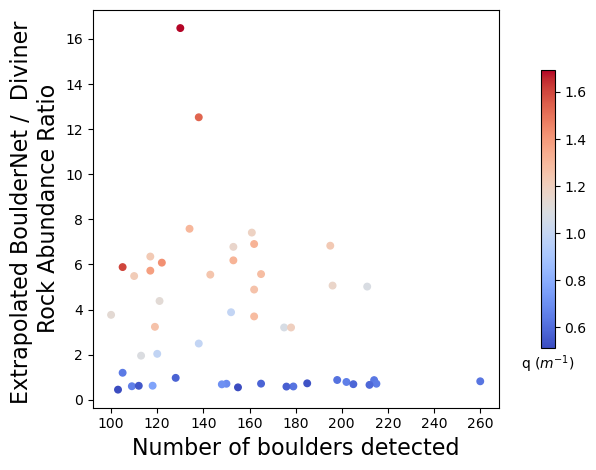

In [17]:
ratios = boulderNet_ra_vals/diviner_ra_vals 

scatter = plt.scatter(num_boulders, ratios, marker='o', s=22, c=q_vals, cmap='coolwarm')
colorbar = plt.colorbar(scatter, pad=0.08, shrink=0.7)
colorbar.ax.set_xlabel('q $(m^{-1})$') 
plt.xlabel("Number of boulders detected", fontsize=16)
plt.ylabel("Extrapolated BoulderNet /  Diviner \nRock Abundance Ratio", fontsize=16)
plt.tight_layout()
plt.show()


# Figure 5 (Qualitative Q Comparison)

In [18]:
# Requires the code for figure 4 to be ran first

# (a)
a = np.argmax(center_tile_indices)
print(q_vals[a])
print(center_tile_indices[a])
print(divinerRAs[a])
print(corrBoulderNetRAs[a])
print(boulderNetRAs[a])

print()

# (b)
b = 24 
print(q_vals[b])
print(center_tile_indices[b])
print(divinerRAs[b])
print(corrBoulderNetRAs[b])
print(boulderNetRAs[b])

0.638478614702316
626
0.01921612034215211
0.023018296021819904
0.004102977777777777

1.6061553487468871
446
0.018827331032007177
0.1107726187508702
0.002722992222222222


# Figure 6 (Diviner Threshold Analysis)

In [19]:
bouldersGDF= pd.read_csv("Data/BouldersWithTileID.csv")
bouldersGDF['diameter'] = 2 *np.sqrt(bouldersGDF['boulder_area'] / np.pi)
tilesDf = pd.read_csv("Data/TileDF.csv").rename(columns={'DivinerRAmean': 'DivinerRA'})

In [26]:
def get_tile_index(grid_height, x, y):
    return x *grid_height + y + 1

divinerRAs = []
boulderNetRAs = []
corrBoulderNetRAs = []
k_vals = []
q_vals = []
mean_diameters = []
num_boulders = []
tile_area = bouldersGDF.tile_area[0]

evalThreshDict = {}

evalThreshes = np.arange(0, 3.4 + 0.05, 0.05)

for evalThresh in evalThreshes:
    evalThreshDict[evalThresh] = []

x_limit = 32
y_limit = 27
for xIndex in range(1, x_limit - 1):
    for yIndex in range(1, y_limit -1):
        potentialTileIndexs = [(xIndex - 1, yIndex - 1),(xIndex - 1, yIndex - 0),(xIndex - 1, yIndex + 1),
                                (xIndex - 0, yIndex - 1),(xIndex - 0, yIndex - 0),(xIndex - 0, yIndex + 1),
                                (xIndex + 1, yIndex - 1),(xIndex + 1, yIndex - 0),(xIndex + 1, yIndex + 1)]
        
        potentialTileIndicies = [get_tile_index(x_limit, pos[0], pos[1]) for pos in potentialTileIndexs]
        actualTiles = tilesDf[tilesDf["id"].isin(potentialTileIndicies)]
        avgArealFrac = actualTiles.ArealFrac.mean()

        if (len(actualTiles) == 0):
            continue
        
        divinerRA = actualTiles['DivinerRA'].mean()
        boulderNetRA = actualTiles['ArealFrac'].mean()
        
        boulders = bouldersGDF[bouldersGDF["id"].isin(potentialTileIndicies)]
        if (len(boulders) < 100):
            continue

        diameterVals, arealFractionVals = get_cumulative_area(boulders, total_area=tile_area*9, minimum=3.38) 

        params, pcov = curve_fit(lambda D,k,q:  rock_abundance_function(D, k, q),  diameterVals,  arealFractionVals,  p0=(0.01, 1))
        k = params[0]
        q = params[1]
        
        k_vals.append(k)
        q_vals.append(q)

        divinerRAs.append(divinerRA)
        boulderNetRAs.append(boulderNetRA)  
        
        mean_diameter = np.mean(boulders['diameter'])
        mean_diameters.append(mean_diameter)

        num_boulders.append(len(boulders))

        
        for evalThresh in evalThreshDict:
            evalThreshDict[evalThresh].append(rock_abundance_function(evalThresh, k, q))


In [21]:
thresholds = sorted(evalThreshDict.keys(),reverse=True)
correctThresholds = []
for i in range(len(divinerRAs)):
    errors = []
    for evalThresh in thresholds:
        uncorrRockAbundance = evalThreshDict[evalThresh][i]
        errors.append(np.abs(divinerRAs[i] - uncorrRockAbundance))
    threshold = thresholds[np.argmin(errors)]
    correctThresholds.append(threshold)

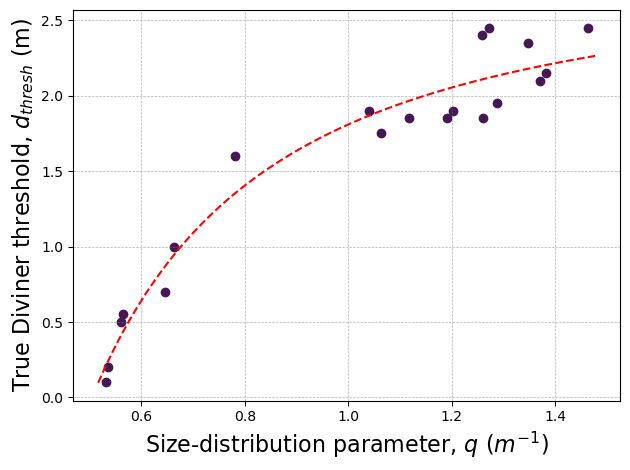

In [22]:
def model_func(x, a, b, c):
    return a + b*x**c

params, covariance = curve_fit(lambda x,a,b,c:  model_func(x, a, b, c), q_vals, correctThresholds, p0=(1, -1, -1))

a, b, c = params

x_fit = np.linspace(min(q_vals)*0.97, max(q_vals)*1.01, 100)
y_fit = model_func(x_fit, a, b, c)

plt.scatter(q_vals, correctThresholds, color = "#431853") 
plt.plot(x_fit, y_fit, color='red', linestyle='--')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)
plt.xlabel("Size-distribution parameter, $q\ (m^{-1})$", size = 16)
plt.ylabel("True Diviner threshold, $d_{thresh}$ (m)", size = 16)
plt.tight_layout()
plt.show()

In [23]:
model_func(0.7667, a, b, c) #Estimate for threshold for entire study area

1.3122145458583259

# Figure 7 (Spatial Parameter Distribution Analysis)

In [27]:
# Data used to create the grid in QGIS

# Requires the code for figure 4 to be ran first

indicies_q_copy = dict()

for index in sorted(indicies_q):
    indicies_q_copy[index] = np.round(np.mean(indicies_q[index]), 4)

print(indicies_q_copy)

indicies_k_copy = dict()

for index in sorted(indicies_k):
    indicies_k_copy[index] = np.round(np.mean(indicies_k[index]), 4)

print(indicies_k_copy)

indicies_corr_ra_copy = dict()

for index in sorted(indicies_corr_ra):
    indicies_corr_ra_copy[index] = np.round(np.mean(indicies_corr_ra[index]), 4)

print(indicies_corr_ra_copy)

{285: 1.3042, 286: 1.2598, 287: 1.2598, 288: 1.2154, 299: 1.5372, 300: 1.6159, 301: 1.6159, 302: 1.6946, 312: 1.3116, 313: 1.2715, 314: 1.2435, 315: 1.198, 316: 1.1311, 326: 1.5372, 327: 1.6159, 328: 1.6159, 329: 1.6946, 339: 1.3017, 340: 1.242, 341: 1.1971, 342: 1.1344, 343: 1.0627, 353: 1.5372, 354: 1.6159, 355: 1.6159, 356: 1.6946, 358: 1.1609, 359: 1.1718, 360: 1.1893, 361: 1.2036, 362: 1.2243, 366: 1.2867, 367: 1.2107, 368: 1.1538, 369: 1.0873, 370: 1.0399, 384: 1.3837, 385: 1.2366, 386: 1.2242, 387: 1.1819, 388: 1.1913, 389: 1.1771, 393: 1.2705, 394: 1.1375, 395: 1.0966, 396: 1.027, 397: 0.9942, 411: 1.403, 412: 1.2779, 413: 1.2645, 414: 1.208, 415: 1.2161, 416: 1.1771, 418: 1.6062, 419: 1.6062, 420: 1.4326, 421: 1.1073, 422: 1.079, 423: 1.019, 424: 0.9943, 438: 1.403, 439: 1.3072, 440: 1.2954, 441: 1.2192, 442: 1.2245, 443: 1.1109, 444: 1.1894, 445: 1.2957, 446: 1.3637, 447: 1.4021, 448: 0.9899, 449: 0.9899, 450: 0.9899, 465: 1.4223, 466: 1.3399, 467: 1.3317, 468: 1.2864, 469: 1

This codeblock is simply used to create the colorbars for Figure 7. The code for Figure S3 and 4 needs to be run immediately before

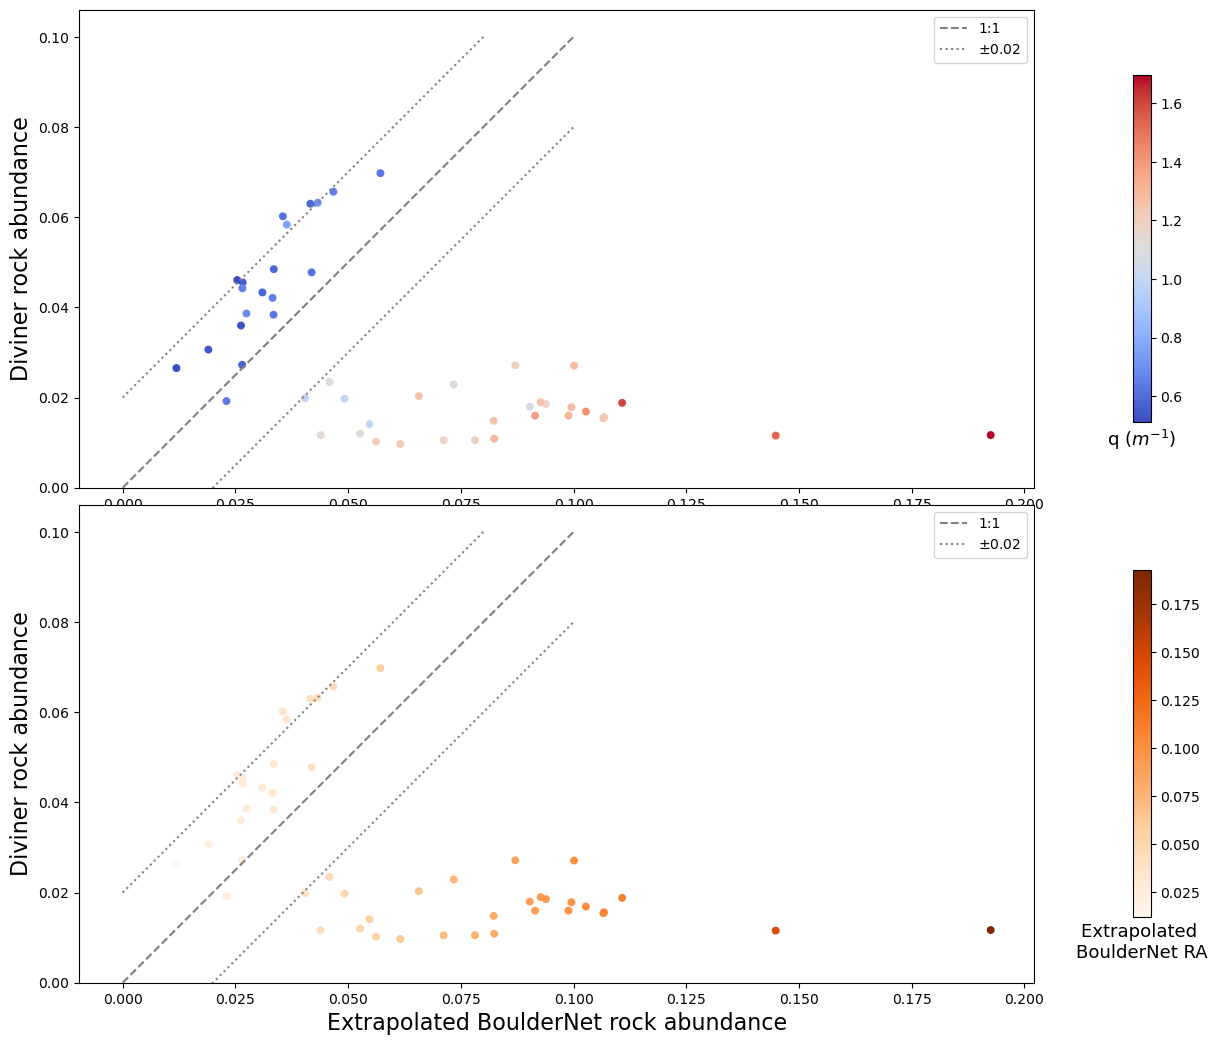

In [36]:
# Create a figure with two vertically stacked subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 18))

# Figure 4a
diviner_ra_vals = np.asarray(divinerRAs) 
boulderNet_ra_vals = np.asarray(corrBoulderNetRAs)

ax1.scatter(boulderNet_ra_vals, diviner_ra_vals, marker='o', s=22, c=q_vals, cmap='coolwarm')#c=k_vals, cmap='Purples')
ax1.set_aspect('equal')  

x_vals = np.array([0, 0.1])  
y_plus_20 = np.array([0, 0.08]) + .02  
y_minus_20 = x_vals - 0.02

ax1.plot(x_vals, x_vals, c='gray', label="1:1", linestyle="--")
ax1.plot(np.array([0, 0.08]), y_plus_20, c='gray', linestyle=':', label="$\pm 0.02$")
ax1.plot(x_vals, y_minus_20, c='gray', linestyle=':')

ax1.set_xlabel("Extrapolated BoulderNet rock abundance", fontsize=16)
ax1.set_ylabel("Diviner rock abundance", fontsize=16)
ax1.set_ylim(ymin=0.0)
ax1.legend(loc='upper right')
cbar1 = plt.colorbar(ax1.collections[0], ax=ax1, pad=0.08, shrink=0.7)
cbar1.ax.set_xlabel('q $(m^{-1})$', fontsize=13)
#cbar1.ax.set_xlabel('k', fontsize=13)

# Figure 4b
ax2.scatter(boulderNet_ra_vals, diviner_ra_vals, marker='o', s=22, c=corrBoulderNetRAs, cmap='Oranges')
ax2.set_aspect('equal')  

ax2.plot(x_vals, x_vals, c='gray', label="1:1", linestyle="--")
ax2.plot(np.array([0, 0.08]), y_plus_20, c='gray', linestyle=':', label="$\pm 0.02$")
ax2.plot(x_vals, y_minus_20, c='gray', linestyle=':')

ax2.set_xlabel("Extrapolated BoulderNet rock abundance", fontsize=16)
ax2.set_ylabel("Diviner rock abundance", fontsize=16)
ax2.set_ylim(ymin=0.0)
ax2.legend(loc='upper right')
cbar2 = plt.colorbar(ax2.collections[0], ax=ax2, pad=0.08, shrink=0.7)
cbar2.ax.set_xlabel('Extrapolated \nBoulderNet RA', fontsize=13)
plt.subplots_adjust(hspace=0, top=0.6, bottom=0.05) 
plt.savefig("Figure 7 (Color Bars q)")
plt.show()

## Supplemental Figure 2 (Model SRF)

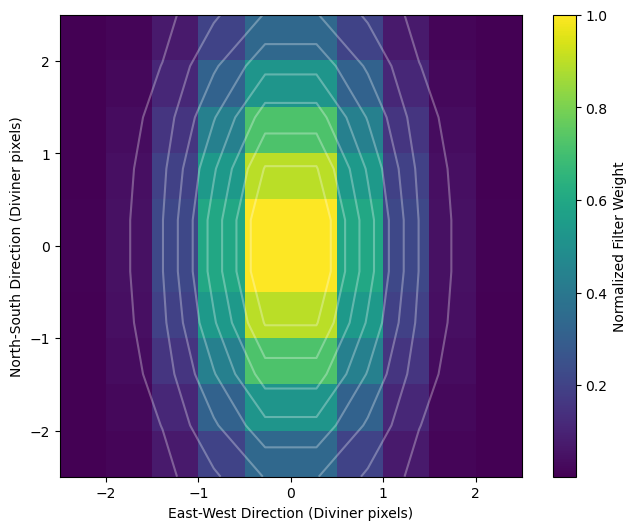

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def create_gaussian_kernel(sigma_x=0.78, sigma_y=1.69, kernel_size=10):
    ax = np.linspace(-(kernel_size//2), kernel_size//2, kernel_size) * 0.5  # Convert to Diviner pixels
    xx, yy = np.meshgrid(ax, ax)
    
    kernel = np.exp(-(xx**2 / (2 * sigma_x**2) + yy**2 / (2 * sigma_y**2)))
    kernel = kernel / (2 * np.pi * sigma_x * sigma_y)
    
    kernel = kernel / kernel.max()
    
    return kernel, xx, yy

kernel, xx, yy = create_gaussian_kernel()

# 2D Heatmap
plt.figure(figsize=(8, 6))
im = plt.imshow(kernel, cmap='viridis', extent=[xx.min(), xx.max(), yy.min(), yy.max()])
plt.xlabel('East-West Direction (Diviner pixels)')
plt.ylabel('North-South Direction (Diviner pixels)')
plt.colorbar(label='Normalized Filter Weight')

# Add contour lines to the heatmap
levels = np.linspace(0, 1, 10)
plt.contour(xx, yy, kernel, levels=levels, colors='white', alpha=0.3)
plt.savefig("Figure S1 (Diviner Model SRF)")
plt.show()

